In [15]:
import time
import pickle

import numpy as np
import random

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from utils import *
from q_learning import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Configurations
save_stats = True
save_figs = True
train = True
load = not train

seed = 0

## 2. Q-Learning

In [17]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000 # number of episodes
num_avg = 1 # training runs
test_freq = 250

### 2.1 Learning from experts

#### Question 1: Average reward with $\epsilon = 0.1$

In [18]:
epsilon_exploration = 0.1
rewards_list = []
for i in range(num_avg):
    print('************** RUN', i+1, 'OF', num_avg, '**************')
    start = time.time()
    Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, verbose=False, against_opt=True)
    rewards_list.append(stats['rewards'])
    print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')

************** RUN 1 OF 1 **************
RUN 1 took 85.2 seconds


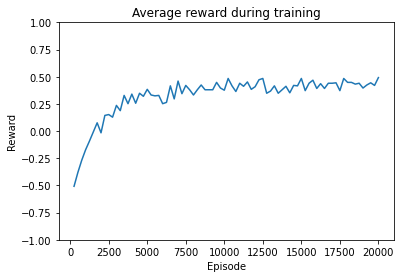


----- Trained  player-----
M_opt =  0.0


In [ ]:
# Plotting the average reward for every 250 games during training
running_rewards_list = []
for reward in rewards_list:
    running_average_rewards, x = running_average(reward)
    running_rewards_list.append(running_average_rewards)

running_average_rewards = np.mean(running_rewards_list, axis=0)
stds = np.std(running_rewards_list, axis=0)
fig = plt.figure()
plt.plot(x, running_average_rewards)
plt.fill_between(x, running_average_rewards - stds, running_average_rewards + stds, alpha=0.2)
plt.ylim([-1,1])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average reward during training')
plt.show()
if save_figs:
        output_folder = os.path.join(os.getcwd(), 'figures')
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + '/rewards_Q1.png')
        fig.savefig(output_folder + '/rewards_Q1.pdf', format = 'pdf')

# Comparing the performance with the optimal player and the random player
turns = np.array(['X','O'])
player_opt = OptimalPlayer(epsilon=0.)
player_rand = OptimalPlayer(epsilon=1.)
teacher = OptimalPlayer(epsilon=0.5)

names = ['Trained', 'Optimal', 'Random']
players = [QPlayer(Q=Q), OptimalPlayer(epsilon=0.), OptimalPlayer(epsilon=1.)]

for (name, player) in zip(names, players):
    print("\n-----", name, " player-----")
    m_opt = measure_performance(player, player_opt)
    print("M_opt = ", m_opt)
    m_rand = measure_performance(player, player_rand)
    print("M_rand = ", m_rand)
    m_teacher = measure_performance(player, teacher)
    print("M_teacher = ", m_teacher)

#### Questions 2 and 3: Decreasing exploration for different values of $n^{*}$

In [12]:
test_freq = 250
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [ ]:
vec_n_star_first = vec_n_star[:10]
var_name = 'nstar_first'
q_learning_params_list = []
for n_star in vec_n_star_first:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq,
              'against_opt': True}
    q_learning_params_list.append(params)

In [ ]:
if train:
    stats_dict_nstar_first_list = train_avg(var_name, vec_n_star_first, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

In [ ]:
var_name = 'nstar_second'
vec_n_star_second = vec_n_star[10:]
q_learning_params_list = []
for n_star in vec_n_star_second:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq,
              'against_opt': True}
    q_learning_params_list.append(params)

In [ ]:
if train:
    stats_dict_nstar_second_list = train_avg(var_name, vec_n_star_second, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

In [ ]:
# Merge
if save_stats:
    stats_dict_nstar_list = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_first_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_first_list = pickle.load(handle)
    fname = output_folder + '/stats_dict_nstar_second_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_second_list = pickle.load(handle)
        for i in range(len(stats_dict_nstar_second_list)):
            stats_dict_nstar_list.append({**stats_dict_nstar_first_list[i], **stats_dict_nstar_second_list[i]})
    fname = output_folder + '/stats_dict_nstar_list.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

plot_n_star = [1., 9146., 19127., 40000]
plot_stats(stats_dict_nstar_list, plot_n_star, 'n_star', "n^{\star}", save=save_figs, decaying_exploration=True)

##### Plot for all the experimented values

In [ ]:
plot_stats(stats_dict_nstar_list, vec_n_star, 'n_star', "n^{\star}", save=False)

#### Questions 4: Good experts and bad experts

In [21]:
n_star = 1 # we pick the best according to previous experiments
M = 3
var_name = 'epsilon_opt'
vec_epsilon_opt = np.round(np.linspace(0, 1, M), decimals=2)
q_learning_params_list = []
for epsilon_opt in vec_epsilon_opt:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': 250,
              'epsilon_opt': epsilon_opt,
              'against_opt': True}
    q_learning_params_list.append(params)

In [22]:
if train:
    stats_dict_eps_opt_list = train_avg(var_name, vec_epsilon_opt, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

************** RUN 1 OF 1 **************
------------- Training with epsilon_opt = 0.0 -------------
M_opt = 0.0
M_rand = 0.07
Training with epsilon_opt = 0.0  took: 00h13m26s 


------------- Training with epsilon_opt = 0.5 -------------
M_opt = 0.0
M_rand = 0.86
Training with epsilon_opt = 0.5  took: 00h11m11s 


------------- Training with epsilon_opt = 1.0 -------------
M_opt = 0.0
M_rand = 0.934
Training with epsilon_opt = 1.0  took: 00h09m15s 




In [ ]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt_19127_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_opt_list = pickle.load(handle)

plot_epsilon_opt = [0., 1.]
plot_stats(stats_dict_eps_opt_list, plot_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=save_figs)

##### Plot for all the experimented values

In [ ]:
plot_stats(stats_dict_eps_opt_list, vec_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=False)

#### Question 5: Optimal values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [15]:
np.random.seed(seed)
random.seed(seed)
# Setting hyperparams
n_star = 1
epsilon_min = 0.1
epsilon_max = 0.8
# Training
Q, stats = q_learning(env, num_episodes=20000, epsilon_exploration_rule=return_lambda_explor(epsilon_min, epsilon_max, n_star), verbose=False, epsilon_opt=0.5, against_opt=True)
# Measuring performance
m_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
print("M_opt = ", m_opt)
m_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
print("M_rand = ", m_rand)

KeyboardInterrupt: 

### 2.2 Learning by self-practice

#### Question 7: Self-learning with constant rate of exploration $\epsilon$

In [6]:
epsilon_vec = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
# epsilon_vec = np.array([0, 0.1, 0.5])
var_name = 'eps_self'
q_learning_params_list = []
for eps in epsilon_vec:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration': eps,
              'test_freq': test_freq,
              'self_practice': True }
    q_learning_params_list.append(params)
# epsilon_vec = np.hstack((epsilon_vec_plot, np.setdiff1d(np.logspace(-4, -1, 10), epsilon_vec_plot)))

In [7]:
if train:
    stats_dict_eps_self_list = train_avg(var_name, epsilon_vec, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

************** RUN 1 OF 1 **************
------------- Training with eps_self = 0.0 -------------
M_opt = -0.964
M_rand = 0.206
Training with eps_self = 0.0  took: 00h08m33s 


------------- Training with eps_self = 0.1 -------------
M_opt = -0.916
M_rand = 0.592
Training with eps_self = 0.1  took: 00h09m05s 


------------- Training with eps_self = 0.5 -------------
M_opt = -0.438
M_rand = 0.754
Training with eps_self = 0.5  took: 00h06m49s 




epsilon_self = 0 : 	M_opt =  -0.964 	M_rand =  0.206
epsilon_self = 0.1 : 	M_opt =  -0.916 	M_rand =  0.592
epsilon_self = 0.5 : 	M_opt =  -0.438 	M_rand =  0.754


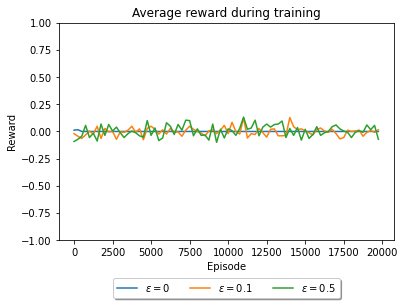

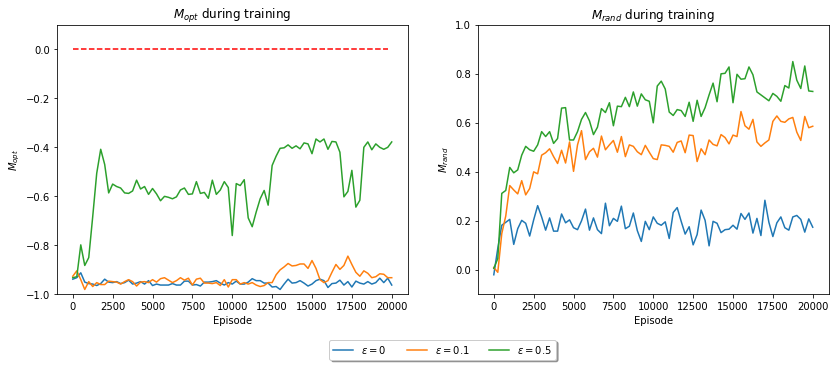

In [8]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_self_list = pickle.load(handle)

epsilon_vec_plot = [0, 0.1, 0.5] # are these okay?
plot_stats(stats_dict_eps_self_list, epsilon_vec_plot, "epsilon_self", "\epsilon", save=save_figs)

##### Plot for all the experimented values

epsilon_self = 0.0 : 	M_opt =  -0.964 	M_rand =  0.206
epsilon_self = 0.1 : 	M_opt =  -0.916 	M_rand =  0.592
epsilon_self = 0.5 : 	M_opt =  -0.438 	M_rand =  0.754


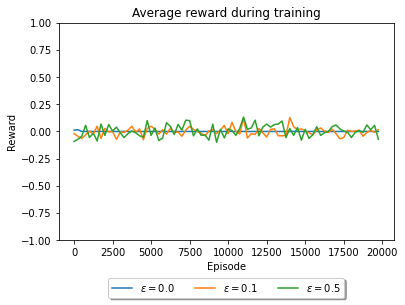

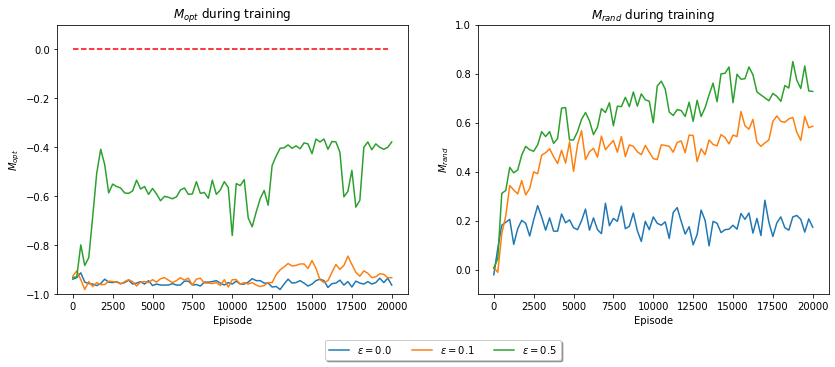

In [9]:
plot_stats(stats_dict_eps_self_list, epsilon_vec, "epsilon_self", "\epsilon", save=False)

#### Question 8: Decaying exploration rule for different values of $n^*$

In [10]:
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [ ]:
var_name = 'nstar_first_self'
vec_n_star_first = vec_n_star[:10]
q_learning_params_list = []
for n_star in vec_n_star_first:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq,
              'self_practice': True}
    q_learning_params_list.append(params)

In [ ]:
if train:
    stats_dict_nstar_self_first_list = train_avg(var_name, vec_n_star_first, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

In [ ]:
var_name = 'nstar_second_self'
vec_n_star_second = vec_n_star[10:]
q_learning_params_list = []
for n_star in vec_n_star_second:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': (return_lambda_explor(epsilon_min, epsilon_max, n_star)),
              'test_freq': test_freq,
              'self_practice': True}
    q_learning_params_list.append(params)

In [ ]:
if train:
    stats_dict_nstar_test = train_avg(var_name, vec_n_star_second, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

In [ ]:
# Merge
if save_stats:
    stats_dict_nstar_self_list = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_first_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_first_self_list = pickle.load(handle)
    fname = output_folder + '/stats_dict_nstar_second_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_second_self_list = pickle.load(handle)
        for i in range(len(stats_dict_nstar_second_self_list)):
            stats_dict_nstar_self_list.append({**stats_dict_nstar_first_self_list[i], **stats_dict_nstar_second_self_list[i]})
    fname = output_folder + '/stats_dict_nstar_self_list.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar_self_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_self_list = pickle.load(handle)

plot_n_star = [1., 9146., 19127., 40000]
plot_stats(stats_dict_nstar_self_list, plot_n_star, 'n_star_self', "n^{\star}", decaying_exploration=True, save=save_figs)

##### Plot for all the experimented values

In [ ]:
plot_stats(stats_dict_nstar_self_list, vec_n_star, 'n_star_self', "n^{\star}", save=False)

#### Optimal values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [12]:
np.random.seed(seed)
random.seed(seed)
# Setting hyperparams
n_star = 10000
epsilon_min = 0.1
epsilon_max = 0.8
# Training
Q, stats = q_learning(env, num_episodes=20000, epsilon_exploration_rule=return_lambda_explor(epsilon_min, epsilon_max, n_star), verbose=False, self_practice=True)
# Measuring performance
m_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
print("M_opt = ", m_opt)
m_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
print("M_rand = ", m_rand)

M_opt =  -0.186
M_rand =  0.492


#### Question 10: Heatmaps of the Q-values in 3 significant states

In [13]:
# Parametri ottimali di Q
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 15000
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)
Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, num_episodes=20000, verbose=True, self_practice=True)

C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


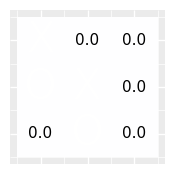

C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


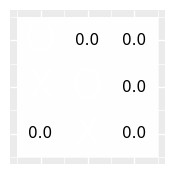

C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 7 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 2 rows containing missing values.


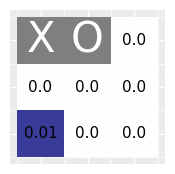

C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 7 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 2 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 7 rows containing missing values.
C:\Users\Federico Betti\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 2 rows containing missing values.


In [14]:
grids = [[1., 0., 0., -1., 1., 0., 0., -1., 0.], [-1., 0., 0., 1., -1., 0., 0., 1., 0.], [1., -1., 0., 0., 0., 0., 0., 0., 0.]]
heatmaps_subplots(grids, Q, save=save_figs)

## Deep Q-Learning